This notebook will demonstrate how to use the **constrained training algorithms** implemented in this toolkit with **PyTorch**-like API.

The algorithms implemented in the **humancompatible.train.torch** subpackage share a similar idea. Before the training, you initialize an algorithm like you would a PyTorch one. Then, during the training process, you:

1. Evaluate a constraint and compute its gradient
2. Call the `dual_step` function to update dual parameters and save the constraint gradient for the primal update
3. Call the `step` function to update the primal parameters (generally, model weights)

Let's try the Stochastic Smooth Linearized Augmented Lagrangian (SSLALM) algorithm on a constrained learning task.

Let's train a simple classification model, putting a constraint on the norm of each layer's parameters.

In the canonical form, the algorithm expects equality constraints that are equal to 0; however, we can easily transform arbitrary inequality constraints to that form.

In [ ]:
# load and prepare data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")
# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [ ]:
from humancompatible.train.algorithms import SSLALM
import torch
from torch.nn import Sequential

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

hsize1 = 64
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

m = len(list(model.parameters()))

optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.01,
    dual_lr=0.1
)
# bounds for the constraints: norm of each param group should be <= 1
constraint_bounds = [1.]*m

epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(epochs):
    loss_log = []
    c_log = []
    slack_log = []
    duals_log = []
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            norm = torch.linalg.norm(param, ord=2)
            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )
            norm_viol.backward()
            # for the Lagrangian family of algorithms, dual_step requires the index of constraint and the value as arguments
            # to update the corresponding dual multiplier
            # in a stochastic-constrained setting, this estimate needs (in theory) to be independent from the one used to update dual parameters
            # in practice, it makes little difference  
            optimizer.dual_step(i, c_val=norm_viol)
            optimizer.zero_grad()
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        optimizer.step()
        optimizer.zero_grad()
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5604039430618286, constraints: [0.8991743  0.2599408  0.9736551  0.4768115  0.86816806 0.08877634], dual: [0.16148867 0.         0.16167231 0.         0.19757077 0.        ]
Epoch: 1, loss: 0.45066189765930176, constraints: [0.9998378  0.6468412  0.9999657  0.5908703  0.99979615 0.03800665], dual: [0.21682546 0.         0.24485189 0.         0.27004305 0.        ]
Epoch: 2, loss: 0.4306633174419403, constraints: [0.99949056 0.9438579  0.99948835 0.6430854  0.9993749  0.05392541], dual: [0.25396693 0.02212644 0.29895452 0.         0.32069972 0.        ]
Epoch: 3, loss: 0.4213128387928009, constraints: [0.9992429  0.9999088  0.99914753 0.6712984  0.9990247  0.06010202], dual: [0.28263575 0.0306577  0.34480694 0.         0.36210668 0.        ]
Epoch: 4, loss: 0.41537511348724365, constraints: [0.9992005  0.9998481  0.99889386 0.6894877  0.9988148  0.06166853], dual: [0.30580273 0.03619856 0.38126972 0.         0.3989226  0.        ]
Epoch: 5, loss: 0.41079315543174744, c

The model is now trained subject to the constraints we set.

---
---

It is also possible to train a network subject to **stochastic constraints**. One of the main use-cases for that is **fairness**. Let's train a network on the `folktables` dataset without constraints first, so we can identify some biases:

Define a model:

In [ ]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_uncon = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

And start training:

In [ ]:
from torch.optim import Adam

loader = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model_uncon.parameters())
epochs = 100

for epoch in range(epochs):
    losses = []
    for batch_feat, batch_label in dataloader:
        optimizer.zero_grad()

        logit = model_uncon(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.4352200786152167
Epoch: 1, loss: 0.395889531456231
Epoch: 2, loss: 0.3817137851197421
Epoch: 3, loss: 0.3695754682874401
Epoch: 4, loss: 0.3568780975500235
Epoch: 5, loss: 0.34210217232449525
Epoch: 6, loss: 0.32594920064692273
Epoch: 7, loss: 0.31021197914489684
Epoch: 8, loss: 0.29461383034331495
Epoch: 9, loss: 0.2771463115070906
Epoch: 10, loss: 0.26328215124150106
Epoch: 11, loss: 0.24740654097924872
Epoch: 12, loss: 0.23411786254895672
Epoch: 13, loss: 0.22124545383622202
Epoch: 14, loss: 0.20866215735330107
Epoch: 15, loss: 0.20019405504988838
Epoch: 16, loss: 0.18898649032322926
Epoch: 17, loss: 0.18045629687645548
Epoch: 18, loss: 0.17240676730290133
Epoch: 19, loss: 0.16458092076684538
Epoch: 20, loss: 0.1599585499406261
Epoch: 21, loss: 0.15455523569742036
Epoch: 22, loss: 0.14654099394031034
Epoch: 23, loss: 0.1420113361795242
Epoch: 24, loss: 0.13897409869821586
Epoch: 25, loss: 0.13559329952540494
Epoch: 26, loss: 0.1296691944350249
Epoch: 27, loss: 0.12

In [ ]:
from fairret.statistic import PositiveRate, TruePositiveRate
from fairret.loss import NormLoss

preds = torch.nn.functional.sigmoid(model_uncon(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3500, 0.5089], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

---
---

Now let us train the same model with one of the **constrained** training algorithms:

Here, to make sure each batch contains representatives of each protected group, we can use the BalancedBatchSampler from the `utils` subpackage - a custom PyTorch `Sampler` which yields an equal number of samples from each subgroup in each batch.

In [ ]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler



dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

# optimizer = SSLALM(
#     params=model_con.parameters(),
#     m=1,
#     lr=0.05,
#     dual_lr=0.05,
#     dual_bound=5,
#     rho=1.,
#     mu=2.
# )

from humancompatible.train.algorithms import SSLALM_Adam

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1,
    lr=0.05,
    dual_lr=0.05,
    dual_bound=5,
    rho=1,
    mu=2,
)

# add slack variables
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

epochs = 150

As the constraint, we use `NormLoss` from `fairret`, which penalizes the model based on the ratio between the value of a statistic for each group and the overall value: $\sum_{s\in S}{|1-\frac{f(\theta, X_s, y_s)}{f(\theta, X, y)}|}$.

In [ ]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        # fair_constraint = torch.max(fair_loss + slack_vars[0] - fair_crit_bound, torch.zeros(1))
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        # calculate loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    ep_c_log.extend(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4854334592819214, constraints: [0.14941066], dual: [0.06504155]
Epoch: 1, loss: 0.40224817395210266, constraints: [0.19466078], dual: [0.064565]
Epoch: 2, loss: 0.3896910548210144, constraints: [0.2010863], dual: [0.0874092]
Epoch: 3, loss: 0.37896525859832764, constraints: [0.19744883], dual: [0.06547313]
Epoch: 4, loss: 0.37186992168426514, constraints: [0.19484382], dual: [0.0341081]
Epoch: 5, loss: 0.36398980021476746, constraints: [0.20067746], dual: [0.04910628]
Epoch: 6, loss: 0.35911378264427185, constraints: [0.20092476], dual: [0.06228149]
Epoch: 7, loss: 0.35065311193466187, constraints: [0.20015445], dual: [0.06728324]
Epoch: 8, loss: 0.34372809529304504, constraints: [0.20029316], dual: [0.06998667]
Epoch: 9, loss: 0.33741721510887146, constraints: [0.19921875], dual: [0.06314257]
Epoch: 10, loss: 0.33004873991012573, constraints: [0.19525294], dual: [0.02840864]
Epoch: 11, loss: 0.32367536425590515, constraints: [0.20550479], dual: [0.07193127]
Epoch: 12

In [ ]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3954, 0.4843], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [ ]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.2015, dtype=torch.float64, grad_fn=<SumBackward0>)

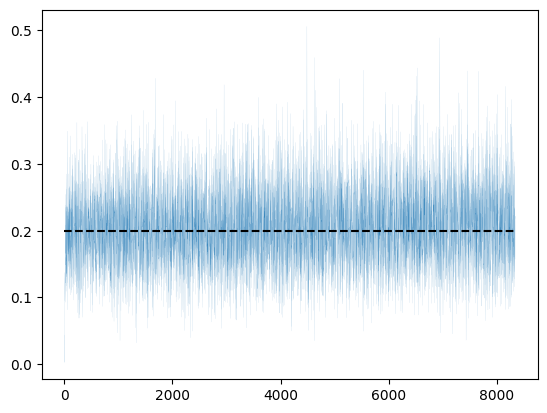

In [ ]:
from matplotlib import pyplot as plt

window_len = 5
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.05)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')

---

Now let's see how the **Switching Subgradient** algorithm deals with this task.

In [ ]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
from humancompatible.train.algorithms import SSG

from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSG(
    params=model_con.parameters(),
    m=1,
    lr=0.05,
    dual_lr=0.05
)

epochs = 150

In [ ]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        # calculate loss and grad
        # batch_output = model_con(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()
        
    ep_c_log.append(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.6008020043373108, constraints: [0.04182665], 
Epoch: 1, loss: 0.44134366512298584, constraints: [0.11503436], 
Epoch: 2, loss: 0.42205706238746643, constraints: [0.11909815], 
Epoch: 3, loss: 0.41317984461784363, constraints: [0.11372222], 
Epoch: 4, loss: 0.4057786762714386, constraints: [0.12013774], 
Epoch: 5, loss: 0.4035780727863312, constraints: [0.11115815], 
Epoch: 6, loss: 0.39891013503074646, constraints: [0.11068783], 
Epoch: 7, loss: 0.3952222466468811, constraints: [0.11964741], 
Epoch: 8, loss: 0.3930428624153137, constraints: [0.11473667], 
Epoch: 9, loss: 0.3915502727031708, constraints: [0.11488518], 
Epoch: 10, loss: 0.3849841356277466, constraints: [0.11364515], 
Epoch: 11, loss: 0.3826874792575836, constraints: [0.11886867], 
Epoch: 12, loss: 0.38164815306663513, constraints: [0.12729581], 
Epoch: 13, loss: 0.3802454471588135, constraints: [0.11590457], 
Epoch: 14, loss: 0.3771109879016876, constraints: [0.12121048], 
Epoch: 15, loss: 0.37501925230

In [ ]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.4253, 0.4686], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [ ]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.0969, dtype=torch.float64, grad_fn=<SumBackward0>)

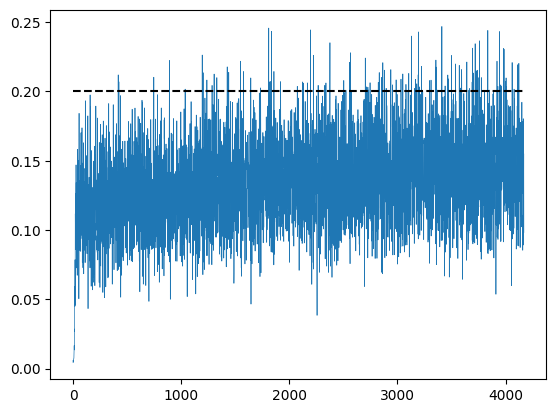

In [ ]:
from matplotlib import pyplot as plt

ep_c_log = np.array(ep_c_log).flatten()
window_len = 10
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.5)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')